## Проверка гипотез по фото

В гипотезах ниже будем считать молодыми людей, чей возраст меньше среднего возраста, и старыми в противном случае.
* Проверьте гипотезу: молодые люди более счастливы, чем старые
* Проверьте гипотезу: женщины более счастливы, чем мужчины
* Проверьте гипотезу: основная эмоция у людей на фотографиях – это счастье (нейтральное выражение лица не учитывать, рассматривать только выраженные эмоции: счастье, грусть и т.д.)
* Вычислите доверительный интервал для среднего возраста мужчин и женщин. Для кого доверительный интервал оказался шире, и почему?

Для извлечения эмоций используем библиотеку [DeepFace](https://pypi.org/project/deepface/):

In [42]:
import sys
!"{sys.executable}" -m pip install deepface

Defaulting to user installation because normal site-packages is not writeable


Подключение основных необходимых модулей

In [43]:
from deepface.detectors import FaceDetector
from deepface import DeepFace
import cv2
import imageio.v3 as iio
import matplotlib.pyplot as plt

Для анализа лица служит функция `analyze` созданная в предыдущем модуле:

Данная функция анализирует только одно лицо, нам необходимо сначала извлечь все лица на фотографии. Это можно сделать с помощью `FaceDetector`:

Функция `analyze` сначала выделяет лица, и потом анализирует каждое из них: 

In [48]:
detector = FaceDetector.build_model("mtcnn")


def analyze(img):
    res = detector.detect_faces(img)
    z = []
    for x in res:
        bb = x['box']
        fc = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2],:]
        a = DeepFace.analyze(fc,enforce_detection=False,prog_bar=False)
        z.append({ "box" : bb, "face" : fc, 
                   "emotion" : a['emotion'], "dominant_emotion" : a['dominant_emotion'], 
                   "age" : a['age'], "gender" : a['gender'],
                   "happy": a['emotion']['happy'],
                   "sad": a['emotion']['sad']})
    return z

Пробный запуск функции analyze с одной групповой фотографией

1/1 [==============================] - 1s 972ms/step


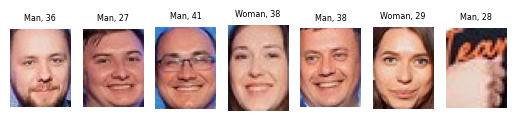

In [49]:
img = iio.imread("images/2_3/IMG_4052.jpg")
res = analyze(img)
fig, ax = plt.subplots(1, len(res))
for i, x in enumerate(res):
    ax[i].imshow(x['face'])
    ax[i].axis('off')
    ax[i].set_title(f"{x['gender']}, {x['age']}").set_fontsize('xx-small')

### Анализ фотографий с разных мероприятий

В качестве материала для анализа рекомендуется взять фотографии с какого-то мероприятия, на котором присутствует много людей.

In [50]:
import os
import pandas as pd


c = 'images/work3/'
l = []

for fn in os.scandir(c):
    if fn.is_file():
        f = os.path.join(c,fn.name)
        i = iio.imread(f)
        a = analyze(i)
        
        print(f)
        # print(type(a))
        #print(a)

        p = pd.DataFrame(a)

        l.append(p[{'gender', 'dominant_emotion', 'age', 'happy', 'sad'}])

m = pd.concat(l, ignore_index=True)
original_data = m[:]

m['happy'] = m['happy'].astype(float)
m['sad'] = m['sad'].astype(float)


print(m)

print(
    f"Уровень счастья у женщин = {m[(m['gender'] == 'Woman')]['happy'].mean()}%")
print(
    f"Уровень счастья у мужчин = {m[(m['gender'] == 'Man')]['happy'].mean()}%")

1/1 [==============================] - 1s 900ms/step
images/work3/068.jpg
1/1 [==============================] - 1s 965ms/step
images/work3/095.jpg
1/1 [==============================] - 1s 940ms/step
images/work3/098.jpg
1/1 [==============================] - 1s 1s/step
images/work3/132.jpg
1/1 [==============================] - 1s 999ms/step
images/work3/AgriTech2022-0017.jpg
1/1 [==============================] - 1s 966ms/step
images/work3/AgriTech2022-0020.jpg
1/1 [==============================] - 1s 968ms/step
images/work3/AgriTech2022-0029.jpg
1/1 [==============================] - 1s 939ms/step
images/work3/AgriTech2022-0048.jpg
1/1 [==============================] - 1s 1s/step
images/work3/AgriTech2022-0052.jpg
1/1 [==============================] - 1s 935ms/step
images/work3/AgriTech2022-0053.jpg
1/1 [==============================] - 1s 973ms/step
images/work3/AgriTech2022-0058.jpg
1/1 [==============================] - 1s 1s/step
images/work3/AgriTech2022-0061.jpg
1/1 [====

Зависимость счастья от возраста и пола

    gender           sad  age dominant_emotion      happy
0    Woman  2.224702e+01   31            angry   0.100662
1    Woman  8.321873e-08   26            happy  99.936104
2    Woman  1.362746e-03   24            happy  96.557695
3    Woman  4.574002e-02   28            happy  98.574787
4    Woman  3.291890e-05   29            happy  99.739230
..     ...           ...  ...              ...        ...
579    Man  1.101140e-08   37            happy  99.999976
580    Man  1.193774e-04   37          neutral  32.464585
581    Man  4.607426e+01   29            angry   0.115980
582    Man  6.117717e-01   29            happy  81.727859
583    Man  6.366759e+01   32              sad   0.001776

[584 rows x 5 columns]
           sad      happy
age                      
20    5.098058   0.001565
21    0.026640  93.904715
22   25.411757  25.521461
23   20.625342  35.230179
24   26.960128  26.288716
25   30.246088  23.822284
26   22.347436  30.928173
27   23.457986  22.582380
28   20.323861  26.6

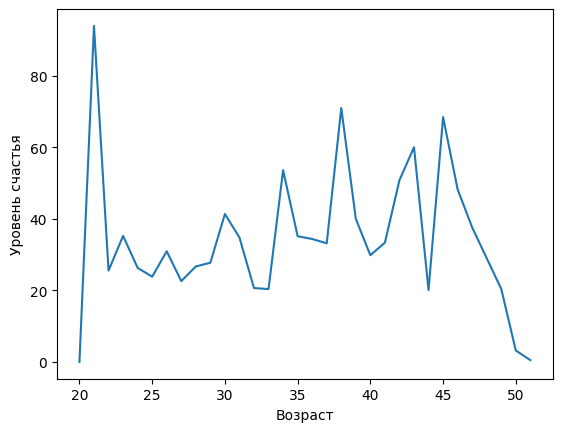

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

print(m)
m = m.groupby('age').mean()
m = m.sort_values(by='age')
print(m)

plt.figure("Счастье/Возраст")
plt.plot(m.index.values, m['happy'])

# naming the x axis
plt.xlabel('Возраст')
# naming the y axis
plt.ylabel('Уровень счастья')

plt.show()